In [1]:
import numpy as np
import thinkstats2
import thinkplot
import random
import nsfg

thinkstats2.RandomSeed(17)

# 09. 假设检验
本章代码位于`hypothesis.py`中。

## 9.1 经典假设检验
在探索NSFG数据的过程中，我们看到了几个`直观效应`，其中包括第一胎和其他胎的区别。到目前为止，我们看到的只是表面现象，本章则将对这些效应进行检验。

我们想解答的基本问题是，在一个样本中观察到的效应是否也会出现在更大规模的总体中。例如，在NSFG样本中，第一胎和其他胎的妊娠期长度不同，我们想了解这种效应是真实反映了美国妇女的生育情况，还是偶然出现在这个样本中而已。

这个问题有好几种表示方法，包括`Fisher原假设检验`、`Neyman-Pearson决策理论`和`贝叶斯推理`，大部分人在实践中使用的都是这3种方法。这里我要介绍的是这些方法的一个子集，称为`经典假设检验`（classical hypothesis testing）。

经典假设检验的目的是回答一个问题：“给定一个样本和一个直观效应，这个效应是偶然出现的概率为多少？”回答这个问题的步骤如下：
+ 第一步，选择一个`检验统计量`（test statistic），对直观效应进行量化。在全国家庭增长调查统计示例中，直观效应是第一胎和其他胎的妊娠时间存在差异，因此我们很自然地选择这两个群组的均值差作为`检验统计量`
+ 第二步，定义`原假设`（null hypothesis）。`原假设`是系统的一个模型，所基于的假设是直观效应不为真。在全国家庭增长调查统计示例中，`原假设`是第一胎和其他胎没有区别，即两个群组的妊娠时间具有相同的分布
+ 第三步，计算`p值`（p-value）。`p值`是在原假设为真时，直观效应出现的概率。在全国家庭增长调查统计示例中，我们将计算两个群组均值的实际差异，然后计算在原假设为真的情况下，这个差异等于或大于实际值的概率
+ 最后，解释结果。如果`p值`很低，那么我们称这个效应是`统计显著`（statistically significant）的，即不太可能偶然发生。在这种情况下，我们推断，这个效应在大规模总体中出现的可能性更大

上述过程的逻辑与反证法类似。要证明一个数学陈述A，你可以暂时假设A不为真，如果这个假设推导出了矛盾结果，那么就可以断定A确实为真。

同样，为了检验一个如`这个效应为真`的假设，我们暂时假设这个效应不为真，即`原假设`。基于这个假设，我们计算这个直观效应的概率，即`p值`。如果`p值`很低，我们就可以断定原假设不太可能为真。

## 9.2 假设检验
`thinkstats2`提供一个类`HypothesisTest`，表示一个经典假设检验结果，定义如下：

In [2]:
class HypothesisTest(object):
    def __init__(self, data):
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)

    def PValue(self, iters=1000):
        self.test_stats = [self.TestStatistic(self.RunModel())
                           for _ in range(iters)]

        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters

    def TestStatistic(self, data):
        raise UnimplementedMethodException()

    def MakeModel(self):
        pass

    def RunModel(self):
        raise UnimplementedMethodException()

`HypothesisTest`是一个抽象父类，完整定义了一些方法，并为其他方法预留接口。基于`HypothesisTest`的子类继承了`__init__`和`PValue`，实现了`TestStatistic`和`RunModel`，可选择是否定义`MakeModel`。

`__init__`可以以任何适宜数据为参数。`__init__`调用`MakeModel`构建原假设，然后将数据传递给`TestStatistics`，从而计算样本中的效应规模。

方法`PValue`计算原假设条件下直观效应的概率。`PValue`的参数`iters`是运行模拟的次数。`PValue`第一行生成模拟数据，计算检验统计量并存放在`test_stats`中，返回的结果是`test_stats`中等于或超过检验统计量的观测值`self.actual`的元素所占的比例。

举个简单的例子，假设我们投掷一枚硬币250次，结果得到140次正面和110次反面。基于这个结果，我们怀疑这个硬币质地不均匀，落地时正面朝上的可能性更大。为了检验这个假设，我们计算出当硬币质地均匀时出现这种结果的概率：

In [3]:
class CoinTest(thinkstats2.HypothesisTest):
    def TestStatistic(self, data):
        heads, tails = data
        test_stat = abs(heads - tails)
        return test_stat

    def RunModel(self):
        heads, tails = self.data
        n = heads + tails
        sample = [random.choice('HT') for _ in range(n)]
        hist = thinkstats2.Hist(sample)
        data = hist['H'], hist['T']
        return data

参数`data`是一对整数，即结果为正面和反面的次数。检验统计量是两者的差值，因此`self.actual`为30。

`RunModel`在假设硬币质地均匀的条件下模拟投掷硬币的实验。`RunModel`生成包含250次投掷结果的样本，使用`Hist`计算结果中正面和反面的数量，返回一对整数值。

现在，实例化`CoinTest`并调用`PValue`：

In [4]:
ct = CoinTest((140, 110))
pvalue = ct.PValue()
pvalue

0.062

结果约为0.062。也就是说，如果硬币是质地均匀的，我们预期有6.2%的可能性看到正面和反面的差值达到30的情况。

我们应该如何解释这一结果呢？按照惯例，5%是统计显著的阈值。如果`p值`小于5%，那么我们认为该效应是显著的，否则不是。

但是`5%`这个值是随意设定的，而且（我们稍后将看到）`p值`依赖于检测统计量的选择和原假设模型。因此，我们不应该将`p值`看作一个精确的度量。

**我建议你按照重要性顺序进行解释：如果`p值`小于1%，那么效应不太可能是随机产生的；如果`p值`大于10%，那么效应可以合理解释为随机现象。位于1%和10%之间的`p值`应看作边缘值。因此，在这个示例中，我认为这些数据没有提供足够的证据，无法证明硬币是否质地均匀。**

## 9.3 检验均值差
人们最常检验的效应之一是两组样本的均值差。在全国家庭增长调查数据中，我们看到第一胎比其他胎的妊娠时间稍长，出生体重略轻。现在，我们要看看这些效应是否统计显著。

这些例子的原假设是两组样本的分布相同。对这个原假设建模，一个方法是`置换`（permutation），即从两组中取值混排，把两个组当成一个大组。

In [5]:
class DiffMeansPermute(thinkstats2.HypothesisTest):
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

`data`是一对序列，每组一个序列。检验统计量是两组序列的均值差。

`MakeModel`记录了两个组的大小`n`和`m`，将两组合并形成一个NumPy数组`self.pool`。

`RunModel`将两组合并后的数值混排，分为大小为`n`和`m`的两个组，以此模拟原假设。按照惯例，`RunModel`返回的值与观察值的格式相同。

为了测试妊娠时间的差异，我们运行如下代码：

In [6]:
# 准备数据
preg = nsfg.ReadFemPreg(dct_file='datasets/2002FemPreg.dct',  dat_file='datasets/2002FemPreg.dat.gz')

live = preg[preg.outcome == 1]
firsts = live[live.birthord == 1]
others = live[live.birthord != 1]

In [7]:
data = firsts.prglngth.values, others.prglngth.values
ht = DiffMeansPermute(data)
pvalue = ht.PValue()
pvalue

0.178

计算结果约为0.17，即我们预期有17%的可能性看到妊娠时间差达到所观测的差值。因此，这个效应不是统计显著的。

`HypothesisTest`提供方法PlotCdf，绘制检验统计量的分布，并用一条灰线标识观察到的效应规模：

No handles with labels found to put in legend.


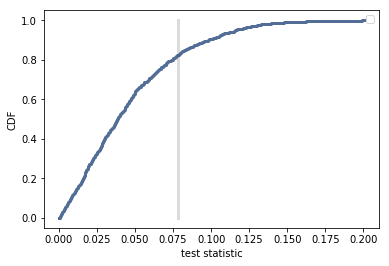

<Figure size 576x432 with 0 Axes>

In [8]:
ht.PlotCdf()
thinkplot.Show(xlabel='test statistic', ylabel='CDF')

上图展示了绘制结果。CDF与观察到的差值在0.83（即`p值`0.17的补）处相交。

如果我们使用新生儿体重数据进行同样的分析，得到的`p值`为0。运行1000次模拟，均值差都没有达到观察到的差值0.12磅。因此，我们将报告$p<0.001$，得出的结论为，新生儿体重的差值是统计显著的。

## 9.4 其他检验统计量
你应当根据需要解决的实际问题选择检验统计量。例如，如果研究第一胎的妊娠时间是否与其他胎不同，那么检验均值差就是很好的选择，我们在前一节中正是这么做的。

如果我们有理由认为第一胎可能出生较晚，那么就不应该检验差值，而是使用另一个的检验统计量。

In [9]:
class DiffMeansOneSided(DiffMeansPermute):
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.mean() - group2.mean()
        return test_stat

`DiffMeansOneSided`从父类`DiffMeansPermute`继承了`MakeModel`和`RunModel`方法，唯一的不同是`TestStatistic`方法计算的是组一均值减去组二均值，没有取绝对值。这种检验只检查差值分布的一侧，因此称为`单侧的（one-sided）检验`。之前的检验使用差值分布的两侧，因而称为`双侧的（two-sided）检验`。

这一版本测试得到的`p值`为0.09。单侧检验的`p值`通常约为双侧检验`p值`的一半，但会受分布形状的影响。

我们的单侧假设为第一胎出生较晚，这个假设比双侧假设更为具体，因此`p值`较小。但即便对于这个更具体的假设，差值也不是统计显著的。

我们可以使用同样的框架检验标准差的差值。在`3.3节`中，有一些证据显示第一胎更可能提早或推迟出生，较少准时。因此，我们可以假设第一胎妊娠时间的标准差更高。检验方法如下：

In [10]:
class DiffStdPermute(DiffMeansPermute):
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.std() - group2.std()
        return test_stat

我们的假设是第一胎的标准差更高，而不仅仅是不同，因此这个检验是单侧检验。检验得到的`p值`为0.09，不是统计显著的。

## 9.5 检验相关性
这个框架也可以检验相关性。例如，在全国家庭增长调查数据集中，新生儿体重和母亲年龄的相关性约为0.07。年龄较大的母亲似乎产下的孩子更重。但是，这种效应是偶然产生的吗？

可以选择`Pearson相关性`作为检验统计量，但`Spearman相关性`也是很好的选择。如果我们有理由预期正相关，那么就可以进行单侧检验。但由于我们并没有任何相关证据，因此还是选择使用相关性的绝对值进行双侧检验。

检验的原假设是母亲年龄和新生儿体重之间没有相关性。我们可以将观察值混排进行模拟，在这个模拟世界中，母亲年龄和新生儿体重的分布仍保持不变，但这两个变量之间没有相关性。

In [11]:
class CorrelationPermute(thinkstats2.HypothesisTest):
    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

`data`是一对序列。`TestStatistic`计算`Pearson相关性`的绝对值。`RunModel`将xs进行混排，返回模拟数据。

下面一段代码读取数据并运行检验：

In [12]:
live2 = live.dropna(subset=['agepreg', 'totalwgt_lb'])
data = live2.agepreg.values, live2.totalwgt_lb.values
ht = CorrelationPermute(data)
p_value = ht.PValue()
pvalue

0.178

> **原文这段话没看明白**
> 实际数据的相关性为0.07。检验计算得到的 p 值为0。在1000次重复实验中，模拟得到的最大相关性为0.04。因此，虽然观察到的变量相关性很小，但这种相关性是统计显著的。

这个示例提醒我们，`统计显著`并不一定说明一个效应是重要的，或者在实践中是显著的。`统计显著`只说明一个效应不太可能是偶然产生的。

## 9.6 检验比例
假设你经营一家赌场，怀疑一位顾客使用作弊骰子，也就是说这个骰子经过处理，更容易掷出其中一面。你抓住这位受怀疑的作弊者，没收了骰子，但是还必须证明这个骰子有问题。你将这个骰子掷了60次，得到如下结果：

| 点数 | 1 | 2 |  3 | 4  | 5 | 6 |
| --- | --- | --- |  --- | --- |  --- | --- |
| 频数 | 8 | 9 | 19 | 5 | 8 | 11 |

在这个数据集中，3出现的次数较多，4较少。但是，这些差异是统计显著的吗？

为了检验这个假设，我们可以计算出每个值的预期频数、预期频数与观察频数的差值，以及差值绝对值的和。在这个示例中，我们预期60次投掷里，骰子的每一面都出现10次，观察值与预期值的差值为`[-2, -1, 9, -5, -2, 1]`，差值绝对值的和为20。完全偶然出现这么大差值的概率是多少呢？

下面这个版本的`HypothesisTest`回答了这个问题：

In [13]:
class DiceTest(thinkstats2.HypothesisTest):
    def TestStatistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum(abs(observed - expected))
        return test_stat

    def RunModel(self):
        n = sum(self.data)
        values = [1, 2, 3, 4, 5, 6]
        rolls = np.random.choice(values, n, replace=True)
        hist = thinkstats2.Hist(rolls)
        freqs = hist.Freqs(values)
        return freqs

代码中使用的数据表示一列频数。观察值为`[8, 9, 19, 5, 8, 11]`，预期频数都是10。检验统计量是差值绝对值的和。

原假设是骰子没有问题，因此我们从values中随机抽取样本进行模拟。RunModel使用Hist计算和返回频数列表。计算得到的p值为0.13，如果骰子没有问题，我们预期检验统计量达到或超过观察值的概率为13%。因此，这个直观效应不是统计显著的。

## 9.7 卡方检验
在前一节，我们使用偏差总和作为检测统计量。但是，检测比例时，人们更多使用的是`卡方统计量`：

+ $\displaystyle x^2 = \sum_{i} \frac{(O_i - E_i)^2}{E_i}$

其中$O_i$是观察到的频数， $E_i$是预期频数。计算`卡方统计量`的Python代码如下：

In [14]:
class DiceChiTest(DiceTest):
    def TestStatistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum((observed - expected)**2 / expected)
        return test_stat

将差值求平方（而不是取绝对值）使大偏差值的权重更大。除以`expected`可以将偏差标准化，虽然在这个例子中预期频数都相同，这种做法没有什么效果。

使用卡方统计量计算的$p$值为0.04，明显小于使用偏差和的值0.13。如果我们坚持使用5%的阈值，就会认为受检测的效应是统计显著的。但是，将这两个检验放在一起考虑，我认为结果并不明确。我无法排除骰子有问题的可能性，也不能肯定骰子一定有问题。

这个示例说明了一个重要问题：$p$值取决于检验统计量的选择和原假设模型，有时这些因素决定了一个效应是否统计显著。

## 9.8 再谈第一胎
我们在本章稍前部分研究了第一胎和其他胎的妊娠时间，认为两组样本均值和标准差的直观差异不是统计显著的。但在3.3节，我们看到了妊娠时间分布的几个直观差异，在35~43周范围内差异尤为明显。要判断这些差异是否统计显著，我们可以使用基于卡方统计量的检验。

下面一段代码结合了前几个示例的功能：

In [15]:
class PregLengthTest(thinkstats2.HypothesisTest):
    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

`TestStatistic`计算第一胎和其他胎的卡方统计量，并求和。

`ChiSquared`以一个妊娠时间序列为参数，计算直方图及对应`self.values`的频数列表`observed`，并将预期概率`expected_probs`乘以样本大小，计算出预期频数列表，返回值为卡方统计量`stat`。

全国家庭增长调查数据的总卡方统计量为102，这个数字本身没有什么意义。但在原假设下，1000次重复产生的最大验证统计量是32。对比之下，我们认为观察到的卡方统计量在原假设下不太可能出现，因此这个直观效应是统计显著的。

这个示例说明卡方检验存在一个局限：卡方检验(chi-squared test)可以证明两个群组之间存在差异，但不能揭示这个差异是什么。

## 9.9 误差
在经典假设检验中，如果p值低于某个阈值（常用阈值为5%），那么我们就认为一个效应是统计显著的。这个过程产生了两个问题：
+ 如果一个效应的确是偶然产生的，那么我们将它误判为统计显著的概率是多少？这个概率就是`误报率`（false positive rate）
+ 如果一个效应不是偶然的，那么假设检验失败的概率是多少？这个概率称为`漏报率`（false negative rate）

相对而言，漏报率比较容易计算。如果阈值为5%，那么漏报率就是5%，理由如下：
+ 如果效应不为真，那么原假设成立，因此，通过模拟原假设就可以计算出检验统计量的分布。我们将这个分布称为$\rm CDFT$
+ 重复运行实验，每次得到一个来自$\rm CDFT$的测试统计量`t`。随后，我们计算出`p值`。`p值`是$\rm CDFT$中的随机值大于`t`的概率，即为$1-\rm CDFT(t)$
+ 当$\rm CDFT (t)$大于`95%`，即`t`大于第95百分秩时，`p值`小于5%。而$\rm CDFT$中随机抽取的值大于第95百分秩的概率为多少呢？答案是5%

因此，如果你进行一个阈值为5%的假设检验，20次里会有1次漏报。

## 9.10 功效
误报率受实际效应大小的影响，而通常我们无法得知实际效应的大小，因此误报率较难计算。一个办法是计算一个假定效应大小的误报率。

举个例子，如果我们假设观测到的组间差异是准确的，那么可以以观测样本为总体模型，使用模拟数据运行假设检验。

In [16]:
def FalseNegRate(data, num_runs=100):
    group1, group2 = data
    count = 0

    for i in range(num_runs):
        sample1 = thinkstats2.Resample(group1)
        sample2 = thinkstats2.Resample(group2)

        ht = DiffMeansPermute((sample1, sample2))
        pvalue = ht.PValue(iters=101)
        if pvalue > 0.05:
            count += 1

    return count / num_runs

`FalseNegRate`方法的参数`data`是两个序列，每组一个。每次循环从两组中各抽取一个随机样本，运行假设检验，以此模拟一次实验，然后检查检验结果，计算误报次数。

`Resample`方法以一个序列为参数，使用放回抽样，从中抽取相同长度的样本：
```python
def Resample(xs):
    return np.random.choice(xs, len(xs), replace=True)
```

检验妊娠时间的代码如下：

In [17]:
neg_rate = FalseNegRate(data)
neg_rate

0.0

结果约为70%。这个结果说明，如果妊娠时间均值的实际差异为0.78周，那么我们预期，如果使用这个规模的样本进行实验，结果有70%的可能性为误报。

人们经常用另一种方式描述这个结果：如果实际差异为0.78周，那么我们预期检验通过的可能性只有30%。这个`正确通过率`称为检验的`功效`（power），有时也称为`敏感度`（sensitivity）。这个值反映了一个检验检测出指定大小效应的能力。

在这个示例中，这个检验结果通过的可能性只有30%（假设实际差异为0.78周）。一般说来，我们认为80%的功效是可接受的，因此示例中的检验属于`低功效的`（underpowered）。

通常，假设检验失败并不说明两个群组之间不存在差异，而是说，如果差异的确存在的话，这个差异太小，以至于无法在这种规模的样本中检测到。

## 9.11 复现
严格说来，我在本章演示的假设检验过程并非最佳实践：
+ 首先，我进行了多重检验。如果你运行一个假设检验，那么误报的可能性约为1/20，还在可接受范围内。但是，如果运行20个检验，那么在大多数情况下，你至少应该预期得到1次误报
+ 其次，我使用同一个数据集进行探索和检验。如果你对一个大数据集进行探索性研究，发现了一个惊人的效应，然后又检验这个效应是否显著，结果十有八九会是误报

要弥补多重检验的问题，你可以调整 p 值的阈值，[参见](https://en.wikipedia.org/wiki/Holm-Bonferroni_method)。你也可以选择将数据分区，一部分数据用来探索，另一部分用来检验，如此，上面提到的问题都可以得到解决。

在某些领域，这些弥补或解决方法是必须采取的，或者至少是受到鼓励的。但是我们通常也可以通过重现别人发表的结果，间接解决这些问题。通常，人们将报告某个新发现的第一篇论文视为探索性的，使用新数据复现该结果的后续论文则为验证性的。

实际上，我们的确有机会复现本章的结果。本书第一版使用的是全国家庭增长调查的第6周期数据，发布于2002年。在2011年10月，疾病控制和预防中心发布了基于2006~2010年调查的附加数据。nsfg2.py中包含读取和清洗这些数据的代码。在这个新数据集中：
+ 妊娠时间均值差为0.16周，$p < 0.001$，是统计显著的（原始数据中均值差为0.078周）
+ 新生儿体重的差值为0.17磅，$p < 0.001$（原始数据中差值为0.12磅）
+ 新生儿体重与母亲年龄之间的相关性为0.08，$p < 0.001$（原始数据中相关性为0.07）
+ 卡方差检验结果$p < 0.001$，是统计显著的（原始数据中也是如此）

总之，原始数据中所有统计显著的效应，在新数据集中都得到了复现。此外，妊娠时间差值在原始数据中不显著，在新数据集中这个差值变大，由不显著变为显著。